In [1]:
%load_ext autoreload
%autoreload 2
import gc
import os
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

from matplotlib.patches import Patch, Rectangle
from joblib import Parallel, delayed

from datetime import datetime
from glob import glob
from collections import defaultdict

from lib import Simulation
from lib import Consensus
from lib import Stat
from lib import Log

from lib import ACTIVE_CIRCUITS_PER_SECOND
from lib import ACTIVE_CIRCUITS_PER_SECOND_STD

In [2]:
def join_tables(tables):
    table = defaultdict(list)
    for t in tables:
        for k,v in t.items():
            table[k].extend(v)
    return table
            
def experiment(idx, consensus_filename):
    with open('/tmp/consensus', 'at') as f:
        f.write(consensus_filename + '...\n')
    table_distribution = defaultdict(list)
    table_shared_links = defaultdict(list)
    consensus = Consensus.read(consensus_filename)            
    for is_internal in [False, True]:
        for directed_links in [False, True]:            
            for N in [int(ACTIVE_CIRCUITS_PER_SECOND), int(ACTIVE_CIRCUITS_PER_SECOND*3)]:
                sim = Simulation.from_consensus(
                    consensus, 
                    N=N,                    
                    is_internal=is_internal,
                    directed_links=directed_links, 
                ).simulate()

                table = sim.stat.create_table()
                values = sim.stat.links.values()
                unique, counts = np.unique(list(values), return_counts=True)

                for value, count in zip(unique, counts):                
                    table_distribution['Filename'].append(consensus_filename)
                    table_distribution['Experiment'].append(idx+1)
                    table_distribution['N'].append(N)
                    table_distribution['Internal'].append(is_internal)
                    table_distribution['Directed'].append(directed_links)
                    table_distribution['MultiplexedCircuits'].append(value)
                    table_distribution['Links'].append(count)
                    
                table_shared_links['Filename'].append(consensus_filename)
                table_shared_links['Experiment'].append(idx+1)
                table_shared_links['N'].append(N)
                table_shared_links['Internal'].append(is_internal)
                table_shared_links['Directed'].append(directed_links)
                table_shared_links['SharedLinksPercent'].append(float(table['Shared Links Percent']))
    return (table_distribution, table_shared_links)

In [3]:
cache_prefix = 'paper-distribution-and-growth-'
cache_distribution = cache_prefix + 'distribution.csv.gz'
cache_shared_links = cache_prefix + 'shared-links.csv.gz'

# These consensus files are empty!
consensus_files_blacklist = set([
    '../archive/microdescs-2021-05/consensus-microdesc/25/2021-05-25-09-00-00-consensus-microdesc',    
    '../archive/microdescs-2021-05/consensus-microdesc/25/2021-05-25-10-00-00-consensus-microdesc',
])
if os.path.exists(cache_distribution) and os.path.exists(cache_shared_links):
    table_distribution = pd.read_csv(cache_distribution, index_col=0)
    table_shared_links = pd.read_csv(cache_shared_links, index_col=0)  
    consensus_files_blacklist = consensus_files_blacklist.union(set(table_distribution['Filename']))
    consensus_files_blacklist = consensus_files_blacklist.union(set(table_shared_links['Filename']))
    
consensus_files = list(glob('../archive/microdescs-2021-*/consensus-microdesc/**/*'))

for item in consensus_files_blacklist:
    if item in consensus_files:
        consensus_files.remove(item)
    
print('%d consensus documents already calculated' % len(consensus_files_blacklist))
print('%d consensus documents left' % len(consensus_files))

if consensus_files:
    for sub_consensus_files in np.array_split(consensus_files, len(consensus_files)/158):
        tables = Parallel(n_jobs=16)(delayed(experiment)(idx, con) for idx, con in enumerate(sub_consensus_files))

        tables_distribution, tables_shared_links = zip(*tables)

        table_distribution_new = pd.DataFrame(join_tables(tables_distribution))
        table_shared_links_new = pd.DataFrame(join_tables(tables_shared_links))

        table_distribution = pd.concat([table_distribution, table_distribution_new])
        table_shared_links = pd.concat([table_shared_links, table_shared_links_new])

        table_distribution.to_csv(cache_distribution)
        table_shared_links.to_csv(cache_shared_links)

        print('Last checkpoint %s' % datetime.now())

8714 consensus documents already calculated
0 consensus documents left


In [4]:
table_shared_links = table_shared_links.reset_index()

In [5]:
table_distribution

Filename  Experiment       N  \
0      ../archive/microdescs-2021-05/consensus-microd...           1   98991   
1      ../archive/microdescs-2021-05/consensus-microd...           1   98991   
2      ../archive/microdescs-2021-05/consensus-microd...           1   98991   
3      ../archive/microdescs-2021-05/consensus-microd...           1   98991   
4      ../archive/microdescs-2021-05/consensus-microd...           1   98991   
...                                                  ...         ...     ...   
11812  ../archive/microdescs-2021-08/consensus-microd...         158  290628   
11813  ../archive/microdescs-2021-08/consensus-microd...         158  290628   
11814  ../archive/microdescs-2021-08/consensus-microd...         158  290628   
11815  ../archive/microdescs-2021-08/consensus-microd...         158  290628   
11816  ../archive/microdescs-2021-08/consensus-microd...         158  290628   

       Internal  Directed  MultiplexedCircuits   Links  
0         False     False                    1  179133  
1         False     False                    2    8145  
2         False     False                    3     718  
3         False     False                    4      73  
4         False     False                    5      11  
...         ...       ...                  ...     ...  
11812      True      True                    7      41  
11813      True      True                    8      11  
11814      True      True                    9       8  
11815      True      True                   10       2  
11816      True      True                   12       1  

[9366174 rows x 7 columns]

In [6]:
table_shared_links = table_shared_links[~table_shared_links['N'].isin([98991, 296975])]
table_distribution = table_distribution[~table_distribution['N'].isin([98991, 296975])]

In [7]:
distribution_external_directed = table_distribution[
    (table_distribution['N'] == ACTIVE_CIRCUITS_PER_SECOND) &
    (table_distribution['Internal'] == False) &
    (table_distribution['Directed'] == True)
]

stat = defaultdict(list)
for group, df in distribution_external_directed.groupby('MultiplexedCircuits'):
    links = df['Links']
    count = len(links)
    
    if count == 1:
        continue
    
    mean = np.mean(links)
    std = np.std(links)
    sem = scipy.stats.sem(links)
    ci = scipy.stats.t.interval(0.95, count, loc=mean, scale=sem)
        
    stat['MultiplexedCircuits'].append(group)
    stat['Count'].append(count)
    stat['Mean'].append(mean)
    stat['Std'].append(std)
    stat['Ci95'].append((ci[1]-ci[0])/2)
    stat['Sem'].append(sem)

stat = pd.DataFrame(stat)
stat = stat[stat['Count'] >= np.quantile(stat['Count'], 0.65)]
stat

/usr/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


MultiplexedCircuits  Count           Mean          Std       Ci95  \
0                    1   8712  179271.657599  1340.617906  28.156550   
1                    2   8712    6399.449610   498.090269  10.461224   
2                    3   8712     468.428030    91.704368   1.926036   
3                    4   8712      54.218779    19.436852   0.408226   
4                    5   8662       8.842069     5.362177   0.112945   

         Sem  
0  14.363855  
1   5.336715  
2   0.982553  
3   0.208253  
4   0.057618

In [8]:
total = stat['Mean'][0:].sum()
shared = stat['Mean'][1:].sum()
print('%.1f%%' % (shared/total*100))

3.7%


In [9]:
print('%.1f%%' % (stat['Mean'][1:2].sum()/total*100))

3.4%


In [10]:
print('%.1f%%' % (stat['Mean'][2:].sum()/total*100))

0.3%


In [11]:
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

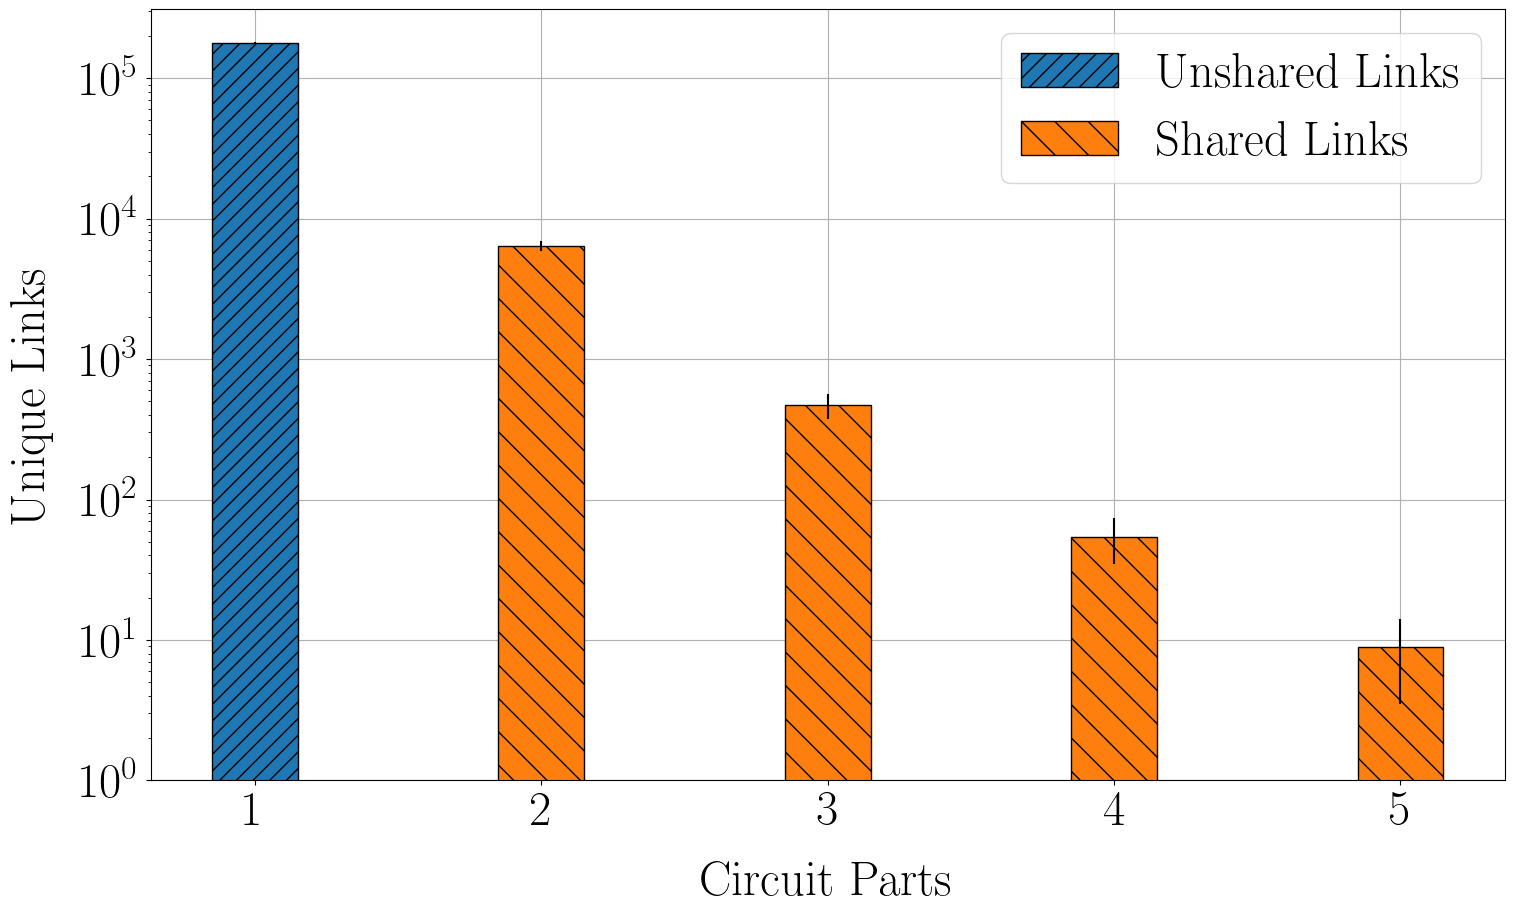

In [12]:
plt.rc('font', family='cmr10')
plt.rc('font', size=35)
plt.rc('axes', axisbelow=True)
plt.rc('figure', figsize=(16, 10))
plt.rc('axes.formatter', use_mathtext=True)

plt.figure(figsize=(16, 10))
cm = plt.get_cmap('tab10')

plt.bar(
    'MultiplexedCircuits', 
    'Mean', 
    color=cm(0.0), 
    hatch='//',
    width=0.3, 
    edgecolor='black', 
    data=stat[stat['MultiplexedCircuits'] == 1]
)

plt.bar(
    'MultiplexedCircuits', 
    'Mean', 
    color=cm(0.1), 
    hatch='\\',
    width=0.3, 
    edgecolor='black', 
    data=stat[stat['MultiplexedCircuits'] > 1]
)

plt.errorbar('MultiplexedCircuits', 'Mean', yerr='Std', c='black', linestyle='None', data=stat)

plt.yscale('log')
plt.ylim(1)

plt.gca().set_axisbelow(True)

plt.legend(handles=[
    Patch(facecolor=cm(0.0), hatch='//', edgecolor='black', label='Unshared Links'),
    Patch(facecolor=cm(0.1), hatch='\\', edgecolor='black', label='Shared Links')
])

plt.xlabel('Circuit Parts', labelpad=20)
plt.ylabel('Unique Links', labelpad=20)

plt.tight_layout()
plt.grid()
plt.savefig('paper-distribution-multiplexed-circuits-current.pdf')
plt.show()

In [13]:
result = table_shared_links[['Experiment', 'N', 'Internal', 'Directed', 'SharedLinksPercent']]
result = result[result['N'] != 100_000]

In [14]:
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)

min_max = result.groupby(['N', 'Internal', 'Directed']).agg([q25, q75, 'mean', 'count', 'std', scipy.stats.sem])['SharedLinksPercent']
min_max = min_max.reset_index(level=0)
min_max = min_max.reset_index(level=0)
min_max = min_max.reset_index(level=0)

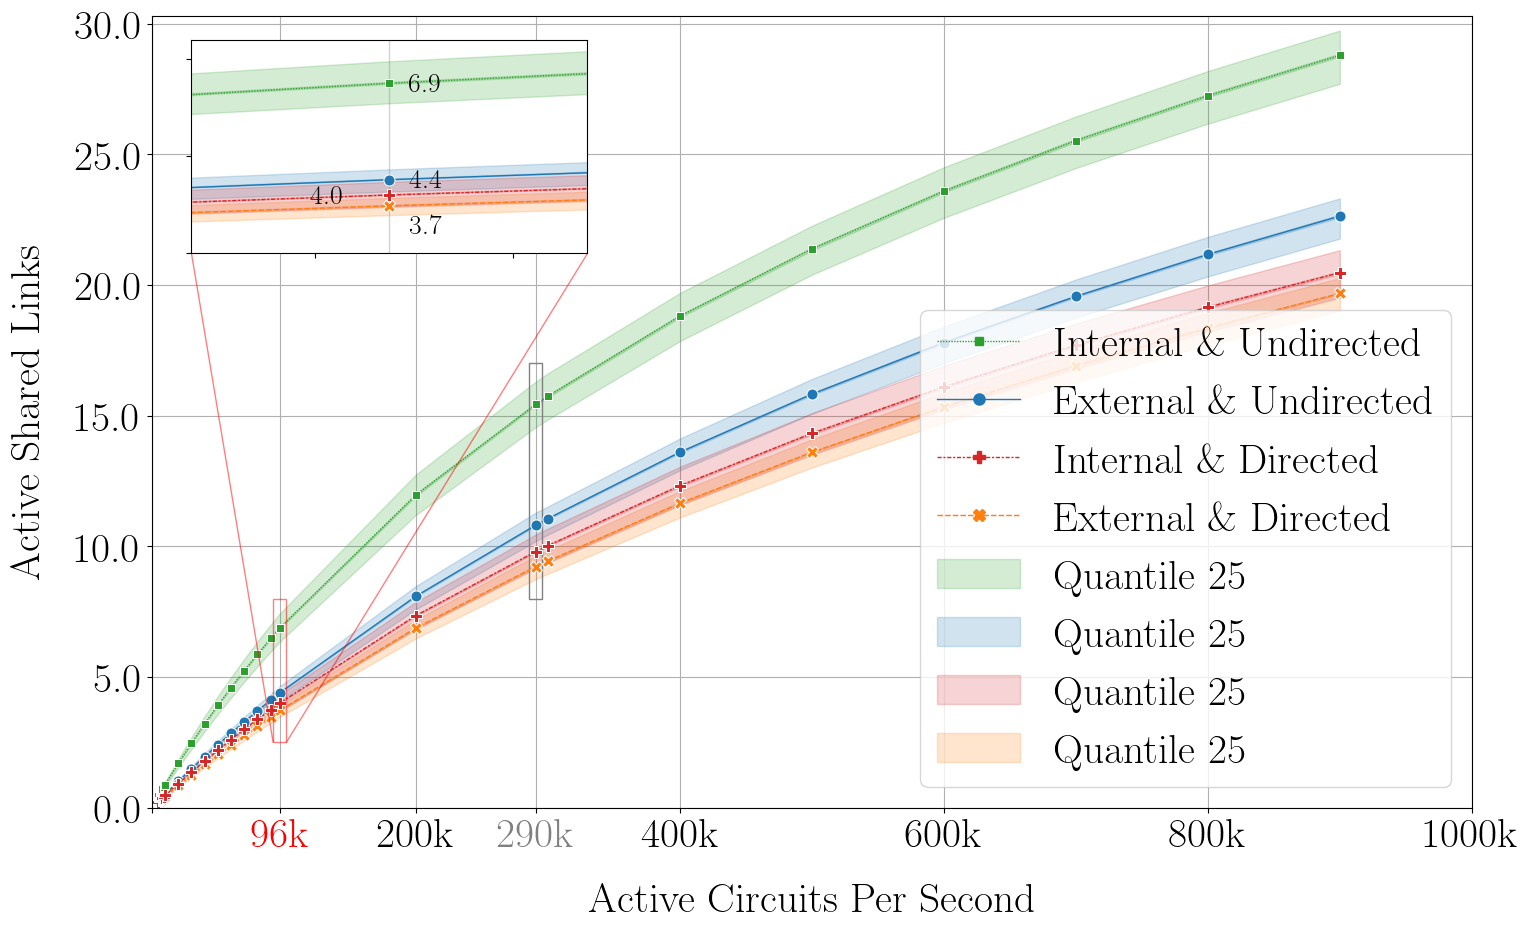

In [17]:
def annotate_value(xy, ax, offset=(1, 1)):
    ax.annotate('%.1f %%' % (xy[1]), xy=xy, xytext=(xy[0] + offset[0], xy[1] + offset[1]), fontsize=20)
    
def format_percent(x, pos=None, digits=1, xmax=100):
    x = x / xmax * 100
    format_string = '%%.%df %%%%' % digits
    return format_string % x

plt.rc('font', family='cmr10')
plt.rc('font', size=30)
plt.rc('axes', axisbelow=True)
plt.rc('axes.formatter', use_mathtext=True)

plt.figure(figsize=(16, 10))
sns.lineplot(
    data=result, 
    x="N", y="SharedLinksPercent", 
    errorbar=('ci', 100), 
    hue=result[['Internal', 'Directed']].apply(tuple, axis=1), 
    style=result[['Internal', 'Directed']].apply(tuple, axis=1), 
    marker='o',
    markers=True,
    ax=plt.gca()
)

plt.xlabel('Active Circuits Per Second', labelpad=20)
plt.ylabel('Active Shared Links', labelpad=20)
plt.xlim(0)
plt.ylim(0)
plt.gca().yaxis.set_major_formatter(format_percent)
plt.grid()

ax = plt.gca()
axins = ax.inset_axes([0.03, 0.70, 0.3, 0.27])
sns.lineplot(
    data=result, 
    x="N", y="SharedLinksPercent", errorbar=('ci', 100), 
    hue=result[['Internal', 'Directed']].apply(tuple, axis=1), 
    style=result[['Internal', 'Directed']].apply(tuple, axis=1), 
    marker='o', 
    markers=True,
    legend=None, 
    ax=axins
)
axins.axvline(x=ACTIVE_CIRCUITS_PER_SECOND, color='lightgray', ls='-', lw=1.0, zorder=-100)
axins.set_xlabel(None)
axins.set_ylabel(None)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.grid(False)
axins.set_xlim(ACTIVE_CIRCUITS_PER_SECOND-5000, ACTIVE_CIRCUITS_PER_SECOND+5000)
axins.set_ylim(2.5, 8)
ax.indicate_inset_zoom(axins, edgecolor="red")

get_shared_links = lambda Internal, Directed: result[(result['N'] == ACTIVE_CIRCUITS_PER_SECOND) & 
                                                     (result['Internal'] == Internal) & 
                                                     (result['Directed'] == Directed)].mean()['SharedLinksPercent']

offset=(500, -0.2)
annotate_value((ACTIVE_CIRCUITS_PER_SECOND, get_shared_links(False, True)), ax=axins, offset=(500, -0.7))
annotate_value((ACTIVE_CIRCUITS_PER_SECOND, get_shared_links(False, False)), ax=axins, offset=offset)
annotate_value((ACTIVE_CIRCUITS_PER_SECOND, get_shared_links(True, True)), ax=axins, offset=(-2000, -0.2))
annotate_value((ACTIVE_CIRCUITS_PER_SECOND, get_shared_links(True, False)), ax=axins, offset=offset)

cm = plt.get_cmap('tab10')

for idx, (Internal, Directed) in enumerate([(False, False),(False, True),(True, False),(True, True)]):
    for ax in [plt.gca(), axins]:
        ax.fill_between(
            min_max[(min_max['Internal'] == Internal) & (min_max['Directed'] == Directed)]['N'],
            min_max[(min_max['Internal'] == Internal) & (min_max['Directed'] == Directed)]['q25'], 
            min_max[(min_max['Internal'] == Internal) & (min_max['Directed'] == Directed)]['q75'], 
            alpha=.2,
            color=cm(idx),
            label='Quantile 25 % - 75 %'
        )


rect = Rectangle((ACTIVE_CIRCUITS_PER_SECOND*3-5000, 8), 10000, 9, linewidth=1, edgecolor='gray', facecolor='none')
plt.gca().add_patch(rect)

plt.rc('font', family='cmr10')
plt.rc('font', size=30)
plt.rc('font', weight='normal')
plt.rc('axes', axisbelow=True)
plt.rc('axes.formatter', use_mathtext=True)
plt.rc('lines', linewidth=1.0, markersize=8.0)

xticks = plt.gca().get_xticks()
xticks = list(xticks)
xticks.append(ACTIVE_CIRCUITS_PER_SECOND)
xticks.append(ACTIVE_CIRCUITS_PER_SECOND*3)
xticks = np.array(sorted(xticks))
plt.gca().set_xticks(xticks)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%dk" % (int(x)/1000)))

plt.gca().get_xticklabels()[0].set_color('white')
plt.gca().get_xticklabels()[1].set_color('red')
plt.gca().get_xticklabels()[3].set_color('gray')

legend = plt.legend()
legend.texts[0].set_text('External \& Undirected')
legend.texts[1].set_text('External \& Directed')
legend.texts[2].set_text('Internal \& Undirected')
legend.texts[3].set_text('Internal \& Directed')

handles, labels = plt.gca().get_legend_handles_labels()

labels[0] = 'External \& Undirected'
labels[1] = 'External \& Directed'
labels[2] = 'Internal \& Undirected'
labels[3] = 'Internal \& Directed'

legend = list(zip(handles, labels))
legend = [
    legend[2], legend[0], legend[3], legend[1], 
    legend[4+2], legend[4+0], legend[4+3], legend[4+1]
]

handles, labels = zip(*legend)
plt.gca().legend(handles, labels)

plt.tight_layout()
plt.savefig('paper-growth-shared-links-vs-active-circuits.pdf')
plt.show()